In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
filename = '../data/train.csv'
df = pd.read_csv(filename)
size = df.shape[0]
print('Total size:', size)

Total size: 250000


***
### Cleaning

In [4]:
def compute_missing_values(df, column_name):
    column = df[column_name].to_numpy()
    return column[np.where(column == -999.0)].shape[0]

In [5]:
def nan_columns(df):
    
    columns = []
      
    for column in df.columns[2:]:
        n_nan = compute_missing_values(df, column)
        rel_nan = n_nan / size

        if rel_nan > 0.3:
            columns.append(column)
    
    return columns

In [6]:
columns = nan_columns(df)
df_clean = df.drop(columns, axis=1).drop("Id", axis=1)
df_clean["Prediction"] = df_clean["Prediction"].apply(lambda x: 1 if x == "s" else 0)
df_clean.head()

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
0,1,138.470,51.655,97.827,27.980,3.064,41.928,197.760,1.582,1.396,...,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,113.497
1,0,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,...,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226
2,0,-999.000,162.172,125.953,35.635,3.148,9.336,197.814,3.776,1.414,...,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251
3,0,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,...,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,0.000
4,0,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,...,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.000


***
### Correlation Matrix

In [7]:
corr = df_clean.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
Prediction,1,0.24,-0.35,-0.014,0.19,0.012,-0.015,0.15,-0.2,0.27,0.24,-0.00094,-0.0044,-0.032,0.0015,0.0041,0.022,0.0075,0.14,0.13,0.13
DER_mass_MMC,0.24,1,-0.46,0.17,0.2,0.23,0.046,0.2,-0.017,0.36,0.13,0.0026,-0.0062,0.099,0.01,-0.00074,-0.23,0.0074,0.22,0.22,0.19
DER_mass_transverse_met_lep,-0.35,-0.46,1,0.19,-0.25,0.043,0.018,-0.15,0.35,-0.42,-0.15,-0.0021,0.0011,0.31,-0.0068,0.00034,0.18,-0.016,-0.17,-0.21,-0.21
DER_mass_vis,-0.014,0.17,0.19,1,-0.063,0.58,-0.0007,0.089,0.097,-0.091,0.29,0.0021,-0.0036,0.41,0.0022,-0.002,-0.087,-0.0015,0.053,-0.027,-0.053
DER_pt_h,0.19,0.2,-0.25,-0.063,1,-0.54,0.31,0.83,0.089,0.54,0.41,0.0017,0.0052,0.36,0.0084,-0.0029,0.68,0.0086,0.78,0.62,0.81
DER_deltar_tau_lep,0.012,0.23,0.043,0.58,-0.54,1,-0.15,-0.43,0.047,-0.21,-0.2,0.0036,-0.011,-0.07,0.0007,-0.00078,-0.4,-0.0016,-0.41,-0.35,-0.45
DER_pt_tot,-0.015,0.046,0.018,-0.0007,0.31,-0.15,1,0.38,0.039,0.18,0.096,0.0036,0.0015,0.11,0.008,-0.0042,0.27,0.0025,0.45,0.36,0.4
DER_sum_pt,0.15,0.2,-0.15,0.089,0.83,-0.43,0.38,1,0.11,0.42,0.49,0.002,0.0039,0.46,0.0088,-0.0019,0.52,0.0067,0.9,0.76,0.97
DER_pt_ratio_lep_tau,-0.2,-0.017,0.35,0.097,0.089,0.047,0.039,0.11,1,-0.039,-0.47,0.00061,3.6e-06,0.7,0.0024,-0.0051,0.053,-0.0012,0.05,0.056,0.079
DER_met_phi_centrality,0.27,0.36,-0.42,-0.091,0.54,-0.21,0.18,0.42,-0.039,1,0.14,0.006,-0.0016,0.054,0.012,0.00028,0.18,0.0099,0.42,0.49,0.45


We could probably remove one feature for pairs with correlation > 0.9

#### Drop correlated features

In [8]:
corr = corr.abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
df_clean = df_clean.drop(df_clean[to_drop], axis=1)
to_drop

['PRI_met_sumet', 'PRI_jet_all_pt']

***
### Distribution plots

C:\Users\dsaureli\AppData\Local\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\dsaureli\AppData\Local\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


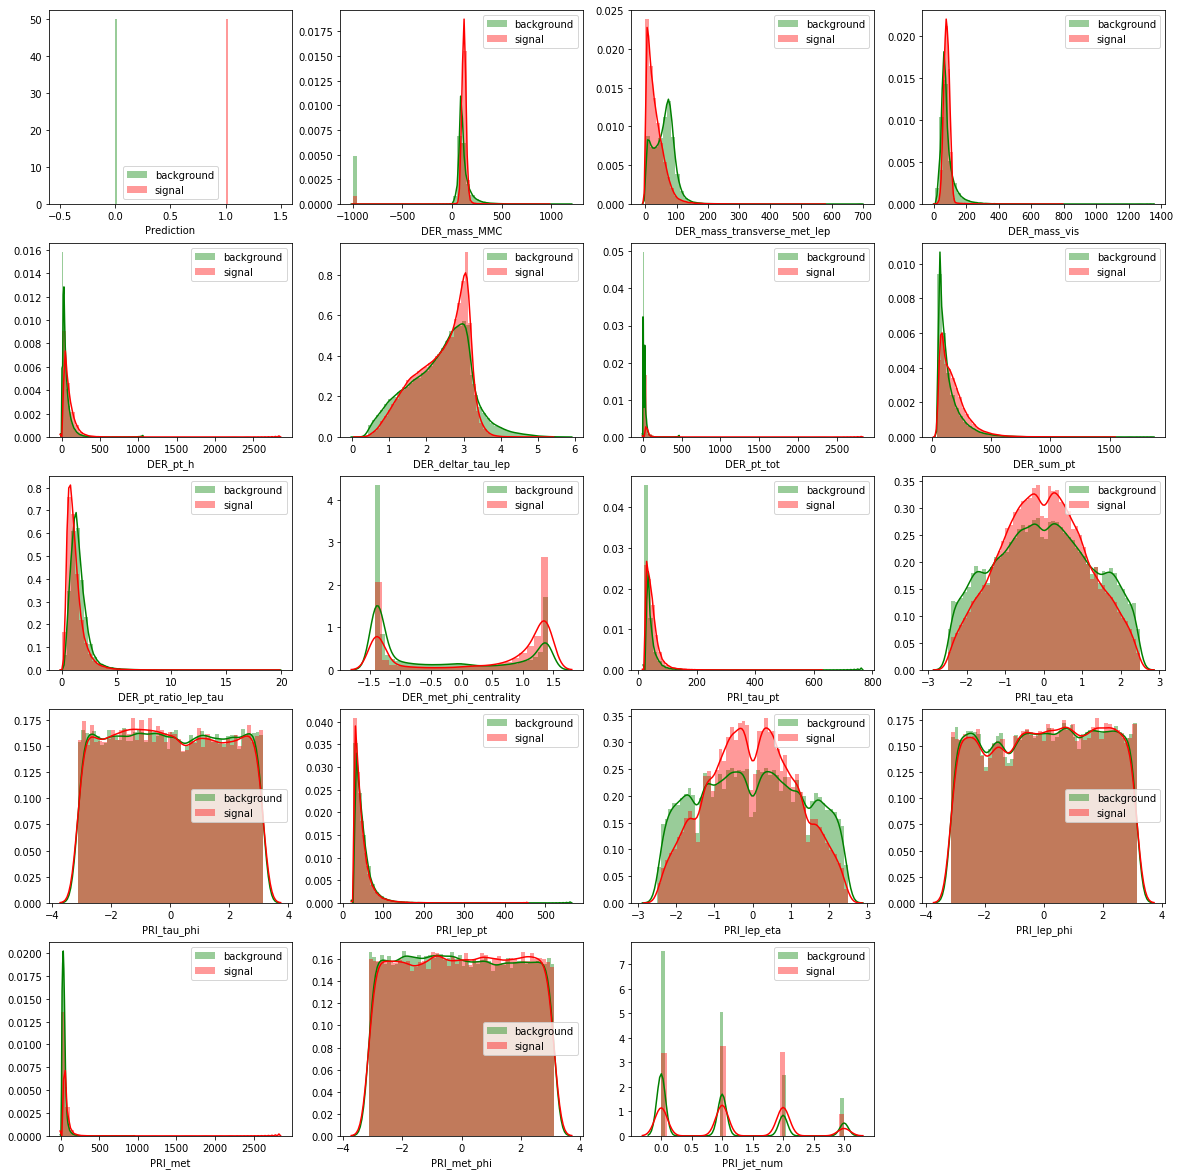

In [9]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df_clean.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df_clean[i][df_clean['Prediction']==0], color='g', label = 'background')
    sns.distplot(df_clean[i][df_clean['Prediction']==1], color='r', label = 'signal')
    plt.legend(loc='best')
plt.show()

In [10]:
desc = df_clean.describe()
desc

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_jet_num
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.342668,-49.023079,49.239819,81.181982,57.895962,2.373100,18.917332,158.432217,1.437609,-0.128305,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,0.979176
std,0.474603,406.345647,35.344886,40.828691,63.655682,0.782911,22.273494,115.706115,0.844743,1.193585,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,0.977426
min,0.000000,-999.000000,0.000000,6.329000,0.000000,0.208000,0.000000,46.104000,0.047000,-1.414000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,0.000000
25%,0.000000,78.100750,19.241000,59.388750,14.068750,1.810000,2.841000,77.550000,0.883000,-1.371000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,0.000000
50%,0.000000,105.012000,46.524000,73.752000,38.467500,2.491500,12.315500,120.664500,1.280000,-0.356000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,1.000000
75%,1.000000,130.606250,73.598000,92.259000,79.169000,2.961000,27.591000,200.478250,1.777000,1.225000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,2.000000
max,1.000000,1192.026000,690.075000,1349.351000,2834.999000,5.684000,2834.999000,1852.462000,19.773000,1.414000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,3.000000


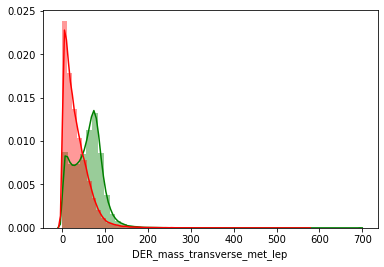

In [11]:
sns.distplot(df_clean[df.columns[3]][df_clean['Prediction']==0], color='g', label = 'background')
sns.distplot(df_clean[df.columns[3]][df_clean['Prediction']==1], color='r', label = 'signal')

In [12]:
df_clean["DER_mass_transverse_met_lep"] = df_clean["DER_mass_transverse_met_lep"].apply(lambda x: np.log(1 + desc["DER_mass_transverse_met_lep"]["min"] + x))

In [13]:
df_clean["DER_mass_transverse_met_lep"].describe()

count    250000.000000
mean          3.555723
std           1.008171
min           0.000000
25%           3.007710
50%           3.861235
75%           4.312114
max           6.538248
Name: DER_mass_transverse_met_lep, dtype: float64

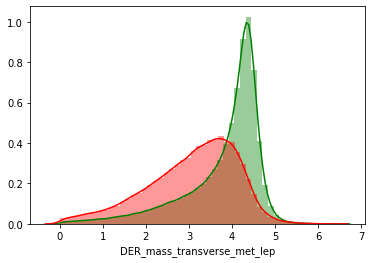

In [14]:
sns.distplot(df_clean[df.columns[3]][df_clean['Prediction']==0], color='g', label = 'background')
sns.distplot(df_clean[df.columns[3]][df_clean['Prediction']==1], color='r', label = 'signal')

In [15]:
desc = df_clean.describe()
to_log_cols = ["DER_mass_transverse_met_lep", "DER_mass_vis", "DER_pt_h", "DER_pt_tot", "DER_sum_pt", "DER_pt_ratio_lep_tau", "PRI_tau_pt", "PRI_lep_pt", "PRI_met"]

for col in to_log_cols:
    df_clean[col] = df_clean[col].apply(lambda x: np.log(1 + desc[col]["min"] + x))

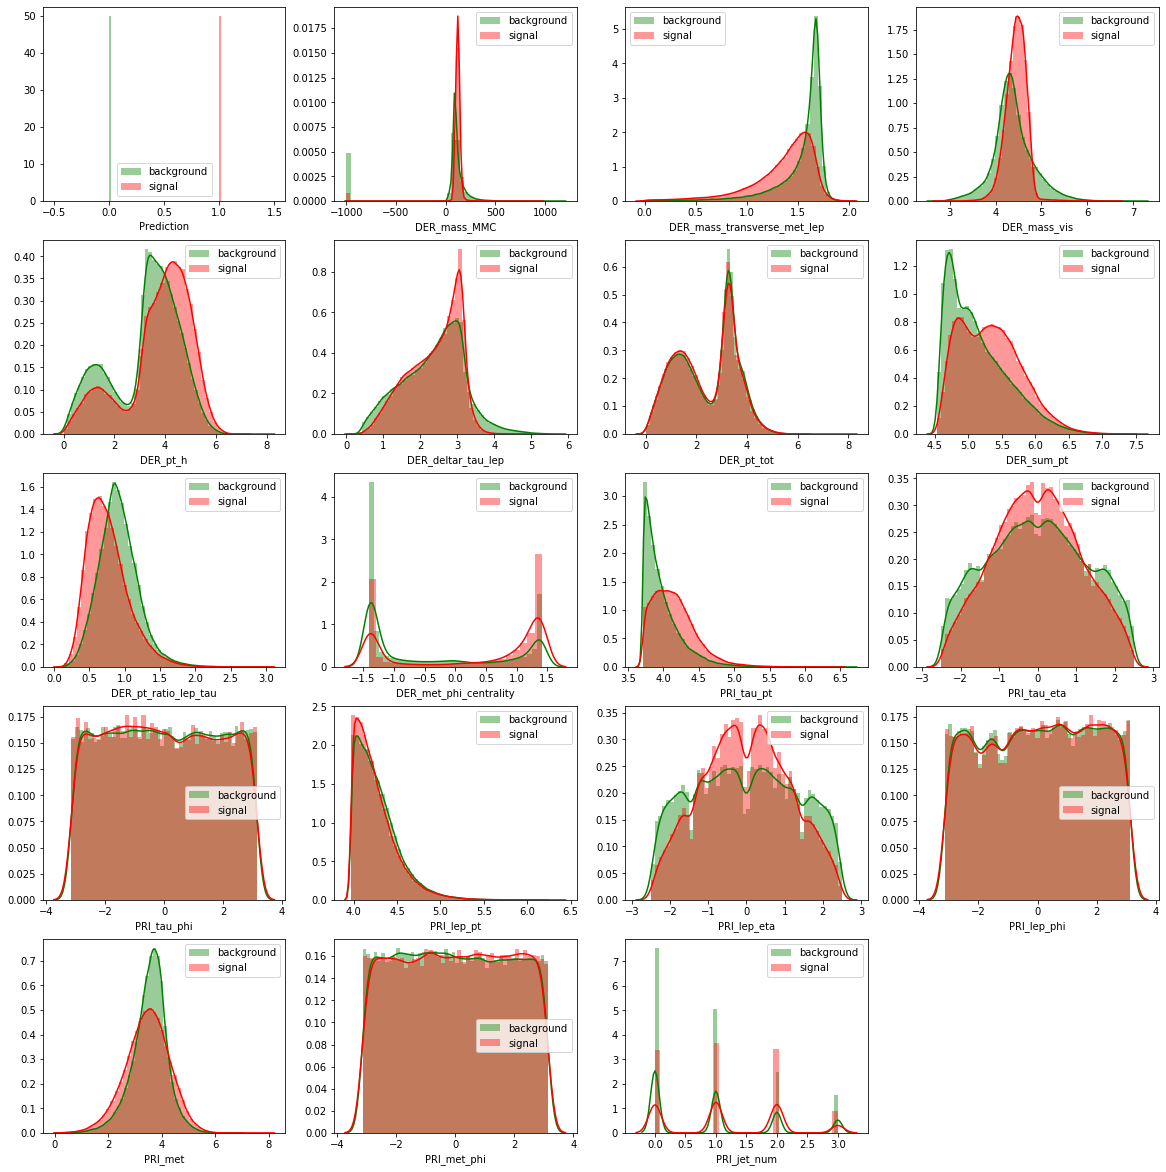

In [16]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df_clean.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df_clean[i][df_clean['Prediction']==0], color='g', label = 'background')
    sns.distplot(df_clean[i][df_clean['Prediction']==1], color='r', label = 'signal')
    plt.legend(loc='best')
plt.show()

In [38]:
to_log_cols_idxs = [list(df_clean.columns).index(x) for x in to_log_cols]
to_log_cols_idxs

[2, 3, 4, 6, 7, 8, 10, 13, 16]

In [35]:
set_1 = [4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
dio = df.columns[1:]
raw_rem = [x for i,x in enumerate(dio) if i not in set_1]
[i for i,x in enumerate(raw_rem) if x in to_log_cols]

[1, 2, 3, 5, 6, 7, 9, 12, 15]

In [36]:
set_2 = [4, 5, 6, 12, 26, 27, 28]
dio = df.columns[2:]
raw_rem = [x for i,x in enumerate(dio) if i not in set_2]
[i for i,x in enumerate(raw_rem) if x in to_log_cols]

[1, 2, 3, 5, 6, 7, 9, 12, 15]